In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Paths
data_dir = "./data/split_dataset"
model_path = "./models/resnet18_spectro.pth"
num_epochs = 10
batch_size = 32
learning_rate = 0.0003

**transforms.Grayscale** – converts input grayscale image into 3 channels that duplicate each other. This is to satisfy the ResNet requirement of 3-channel input. Each of the 3 channels is a duplicate of the original single-channel image and brings no extra information.<br>
**.Resize** - another ResNet requirement - input must be equal Height == Width sizes.<br>
**.ToTensor** - Rescale values in range [0, 255] to  [0.0, 1.0]. Also changes the shape (H, W, C)) into (C x H x W), C - stands for number of channels.<br>
**.Normalize** -  normalizes the tensor values by subtracting a mean and dividing by a standard deviation for each channel, which results in shift data into [-1, 1] range.  which helps in stabilizing and accelerating the training process of neural networks by centering the data around zero with a consistent scale. [Discussion here](https://discuss.pytorch.org/t/understanding-transform-normalize/21730/2).


In [5]:
# Transforms - create callables
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

## Initializing Data Variables

### Dataset: ImageFolder example
- **Number of Data objects**: 146175
- **Root Location**: ./data/split_dataset/train (here are 3 folders for different purposes: train, test, validate)
- **StandardTransform**:
  - **Transform**: Compose(
    - Grayscale(num_output_channels=3)
    - Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    - ToTensor()
    - Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  )


In [6]:
# Datasets - ImageFolder automatically gets class labels from the names of these subdirectories and loads the images accordingly
train_dataset = ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = ImageFolder(os.path.join(data_dir, "test"), transform=transform)

## dataset inicialization - pointing each of train, val and test sets to appropriate data source

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Only trainig dataset is shuffled, update parameters after batch is done
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Performance monitoring, in some cases updates also hyperparameters, such as learning rate
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # Final model performance assessment. 

In [8]:
# Model (Pretrained ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Initialize early stopping variables
best_loss = float('inf')
patience = 5
counter = 0

# Tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training + Validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    # Early stopping and checkpoint
    if val_losses[-1] < best_loss:
        best_loss = val_losses[-1]
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/10 | Train Loss: 0.0022, Train Acc: 0.9996 | Val Loss: 0.0000, Val Acc: 1.0000
Model saved.
Epoch 2/10 | Train Loss: 0.0039, Train Acc: 0.9990 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 3/10 | Train Loss: 0.0018, Train Acc: 0.9996 | Val Loss: 0.0011, Val Acc: 0.9997
Epoch 4/10 | Train Loss: 0.0018, Train Acc: 0.9996 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 5/10 | Train Loss: 0.0018, Train Acc: 0.9996 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 6/10 | Train Loss: 0.0011, Train Acc: 0.9998 | Val Loss: 0.0001, Val Acc: 1.0000
Early stopping triggered.


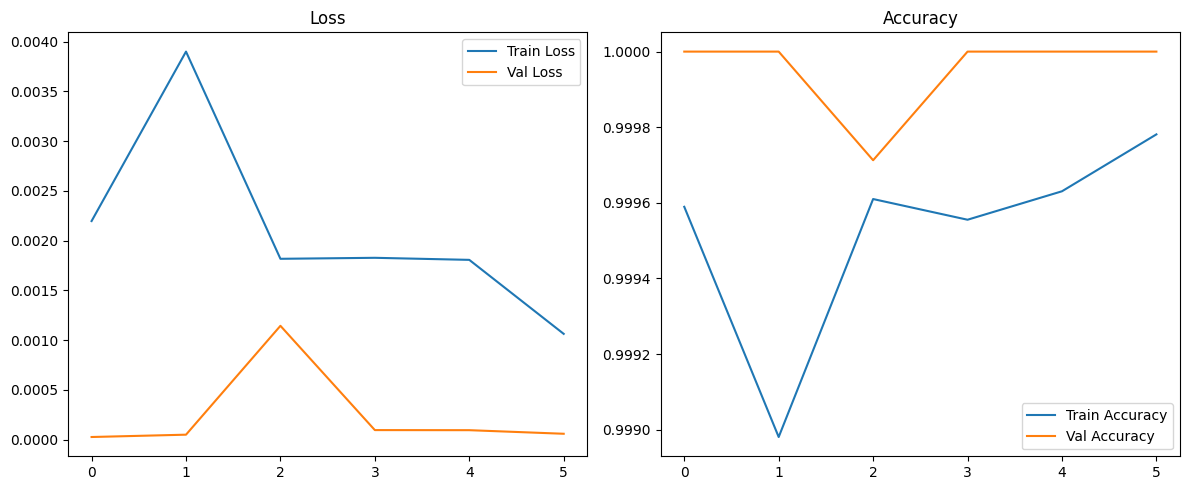

In [15]:
# Save model
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

# Plotting
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## Checking models performance with unseen - test data

In [16]:
# Test the trained model on the test dataset
model.eval()
test_loss, correct, total = 0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0004, Test Accuracy: 0.9999


## Add Dropout for Regularization

In [ ]:
from torch import nn
import torchvision.models as models

class ResNetWithDropout(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNetWithDropout, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Replace original model
model = ResNetWithDropout(num_classes=len(train_dataset.classes)).to(device)


## Add L2 Regularization (Weight Decay)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [11]:
# Transforms - create callables
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])